# Assignment 4: Neural Networks  
# Assignment goal: Optimisation of a Neural Network for Image Classification



# 1. Data processing

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
#I cannot take credit for training loop fully as i did recieve help from deepseek ai to debugg it , while i was trying to make it more flexible ,ffor it to be re-usable

In [18]:
train_df = pd.read_csv('kaggle/fashion-mnist_train.csv') # loading the datases
test_df = pd.read_csv('kaggle/fashion-mnist_test.csv')

In [3]:
def processor(df):
    labels = df['label'].values
    images = df.drop('label', axis=1).values.reshape(-1, 1, 28, 28) / 255.0
    return torch.FloatTensor(images), torch.LongTensor(labels)

In [4]:
train_images, train_labels = processor(train_df)
test_images, test_labels = processor(test_df)

train_dataset = TensorDataset(train_images, train_labels)# my datasets
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#loaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Debugging!")
print(f"training set has : {len(train_dataset)} samples")
print(f"test/validation set has : {len(test_dataset)} samples")

Debugging!
training set has : 60000 samples
test/validation set has : 10000 samples


# 2. Building and training a Baseline model

In [5]:
class NeuralNet(nn.Module):#variable/flexible model definition 
     def __init__(self, hidden1_neurons=128):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28,hidden1_neurons),  # Input layer -> Hidden Layer 1
            nn.ReLU(),
            nn.Linear(hidden1_neurons,64),     # Hidden Layer 1 -> hidden Layer 2  
            nn.ReLU(),
            nn.Linear(64,10)       # hidden Layer 2 -> Output layer
        )
     def forward(self, x):
        x =self.flatten(x)
        return self.network(x)

**Training**

In [6]:
def set_seed(seed=56):#REPRODUCABILITY!!
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(56)

In [7]:
#Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, verbose=True, return_history=True):
    """Args:
        verbose: for printing the progress fo each epochh if set to True
        return_history: If True, for returning  loss/accuracy history is set to True, otherwise only returning the final accuracy"""
    #initialisingthe  history tracking if needed
    train_losses = [] if return_history else None
    val_losses = [] if return_history else None
    val_accuracies = [] if return_history else None
    
    for epoch in range(epochs):
        #trainng
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        
        #validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total
        
        #history storing
        if return_history:
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            val_accuracies.append(accuracy)
        
        #printing the progress if verbose==True
        if verbose:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Training Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Val Accuracy: {accuracy:.2f}%')
    
    #conditional return statements ,based on the parameters
    if return_history:
        return train_losses, val_losses, val_accuracies
    else:
        return accuracy

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device}")

# model, loss function, and optimizer
set_seed(56)
baseline_model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

print("Baseline Model is training...")
set_seed(56)
train_losses, val_losses, val_accuracies = train_model(baseline_model, train_loader, test_loader, criterion, optimizer, epochs=10)

baseline_accuracy = val_accuracies[-1]#taking the final accuracy from the baseline training
print(f"Baseline Validation Accuracy: {baseline_accuracy:.2f}%")

cpu
Baseline Model is training...
Epoch [1/10], Training Loss: 0.5645, Val Loss: 0.4305, Val Accuracy: 84.77%
Epoch [2/10], Training Loss: 0.3998, Val Loss: 0.3769, Val Accuracy: 86.53%
Epoch [3/10], Training Loss: 0.3572, Val Loss: 0.3565, Val Accuracy: 86.82%
Epoch [4/10], Training Loss: 0.3324, Val Loss: 0.3272, Val Accuracy: 88.01%
Epoch [5/10], Training Loss: 0.3134, Val Loss: 0.3347, Val Accuracy: 87.87%
Epoch [6/10], Training Loss: 0.2992, Val Loss: 0.3132, Val Accuracy: 88.49%
Epoch [7/10], Training Loss: 0.2867, Val Loss: 0.3088, Val Accuracy: 88.64%
Epoch [8/10], Training Loss: 0.2735, Val Loss: 0.3083, Val Accuracy: 88.65%
Epoch [9/10], Training Loss: 0.2637, Val Loss: 0.3058, Val Accuracy: 88.76%
Epoch [10/10], Training Loss: 0.2511, Val Loss: 0.2910, Val Accuracy: 89.44%
Baseline Validation Accuracy: 89.44%


# 3. Hyperparameter Optimisation Experiment  
# Chosen Hyperparameters : 
# learning_rates = 0.1, 0.01, 0.001
# optimizers = 'Adam', 'SGD', 'RMSprop'
# Number of neurons in the hidden layer one = 64, 128, 256


In [9]:
learning_rates = [0.005, 0.001, 0.0005]#Hyperparameter combinations to test
optimizers_list = ['Adam', 'SGD', 'RMSprop','AdamW']
neurons_list = [64, 256,512]


results = []
print("Starting hyperparameter experiment...")
print(f"Total combinations-> {len(learning_rates) * len(optimizers_list) * len(neurons_list)}")
print("=" * 50)

combination_count = 0

for lr in learning_rates:
    for opt_name in optimizers_list:
        for neurons in neurons_list:
            combination_count += 1
            print(f"Combination {combination_count}: lr={lr}, optimizer={opt_name}, neurons={neurons}")

            set_seed(56)
            model = NeuralNet(hidden1_neurons=neurons)#taking specified hidden layer one nerons
            criterion = nn.CrossEntropyLoss()
            #taking in specified optimizer
            if opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif opt_name == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            elif opt_name == 'AdamW':
                optimizer = optim.AdamW(model.parameters(), lr=lr)
            
            accuracy = train_model(model, train_loader, test_loader, criterion, optimizer,epochs=10, verbose=False, return_history=False) #train and evaluate
            
            results.append({'learning_rate': lr,'optimizer': opt_name,'neurons': neurons,'accuracy': accuracy })
            
            print(f"  -> Accuracy: {accuracy:.2f}%")
            print("-" * 50)

print(f"Tested All {combination_count} combinations")

Starting hyperparameter experiment...
Total combinations-> 36
Combination 1: lr=0.005, optimizer=Adam, neurons=64
  -> Accuracy: 87.80%
--------------------------------------------------
Combination 2: lr=0.005, optimizer=Adam, neurons=256
  -> Accuracy: 88.41%
--------------------------------------------------
Combination 3: lr=0.005, optimizer=Adam, neurons=512
  -> Accuracy: 88.07%
--------------------------------------------------
Combination 4: lr=0.005, optimizer=SGD, neurons=64
  -> Accuracy: 82.25%
--------------------------------------------------
Combination 5: lr=0.005, optimizer=SGD, neurons=256
  -> Accuracy: 82.74%
--------------------------------------------------
Combination 6: lr=0.005, optimizer=SGD, neurons=512
  -> Accuracy: 83.34%
--------------------------------------------------
Combination 7: lr=0.005, optimizer=RMSprop, neurons=64
  -> Accuracy: 86.40%
--------------------------------------------------
Combination 8: lr=0.005, optimizer=RMSprop, neurons=256
  -

In [19]:
#pandas dataFrame for easy analysis showing the top 10 best
results_df = pd.DataFrame(results)
print("Top 10 best model from Hyper-parameter experiments:")
print("=" * 50)
print(results_df.sort_values('accuracy', ascending=False).head(10))  #top 10 performances

Top 10 best model from Hyper-parameter experiments:
    learning_rate optimizer  neurons  accuracy
32         0.0005   RMSprop      512     89.84
35         0.0005     AdamW      512     89.52
20         0.0010   RMSprop      512     89.43
31         0.0005   RMSprop      256     89.41
26         0.0005      Adam      512     89.39
14         0.0010      Adam      512     89.37
25         0.0005      Adam      256     89.33
23         0.0010     AdamW      512     89.32
22         0.0010     AdamW      256     89.32
13         0.0010      Adam      256     89.30


In [21]:
#pandas dataFrame for easy analysis shwoing the top 10 worst
results_df = pd.DataFrame(results)
print("Top 10 worst models from Hyper-parameter experiments:")
print("=" *50)
print(results_df.sort_values('accuracy', ascending=False).tail(10))

Top 10 worst models from Hyper-parameter experiments:
    learning_rate optimizer  neurons  accuracy
6          0.0050   RMSprop       64     86.40
5          0.0050       SGD      512     83.34
4          0.0050       SGD      256     82.74
3          0.0050       SGD       64     82.25
16         0.0010       SGD      256     68.39
17         0.0010       SGD      512     68.34
15         0.0010       SGD       64     67.76
29         0.0005       SGD      512     61.91
28         0.0005       SGD      256     61.30
27         0.0005       SGD       64     60.29


In [22]:
print("RESULTS ANALYSIS ")
print("="* 50)
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print(f"The Best Combination:")
print(f"Learning rate: {best_result['learning_rate']}")
print(f"Optimizer: {best_result['optimizer']}") 
print(f"Neurons: {best_result['neurons']}")
print(f"Accuracy: {best_result['accuracy']:.2f}%")
print("-" * 50)
baseline_accuracy = 89.44
improvement = best_result['accuracy'] - baseline_accuracy
print(f"Improvement over baseline: {improvement:.2f}%")


print("\nAverage accuracy by Learning Rate:")#group by analysis
print(results_df.groupby('learning_rate')['accuracy'].mean().sort_values(ascending=False))
print("-" * 50)
print("\nAverage Accuracy by optimizer:")
print(results_df.groupby('optimizer')['accuracy'].mean().sort_values(ascending=False))
print("-" *50)
print("\nAverage Accuracy by number of neronsin Layer one:")
print(results_df.groupby('neurons')['accuracy'].mean().sort_values(ascending=False))

RESULTS ANALYSIS 
The Best Combination:
Learning rate: 0.0005
Optimizer: RMSprop
Neurons: 512
Accuracy: 89.84%
--------------------------------------------------
Improvement over baseline: 0.40%

Average accuracy by Learning Rate:
learning_rate
0.0050    86.641667
0.0010    83.871667
0.0005    81.987500
Name: accuracy, dtype: float64
--------------------------------------------------

Average Accuracy by optimizer:
optimizer
Adam       88.713333
AdamW      88.632222
RMSprop    88.620000
SGD        70.702222
Name: accuracy, dtype: float64
--------------------------------------------------

Average Accuracy by number of neronsin Layer one:
neurons
512    84.588333
256    84.376667
64     83.535833
Name: accuracy, dtype: float64


# 4. Part 4: Analysis and Report

In [23]:
#pandas data frame for allexperiments 
print("Hyperparameter Experiment Results")
print("*" * 60)
print(results_df.to_string(index=False))
print("*"* 60)

Hyperparameter Experiment Results
************************************************************
 learning_rate optimizer  neurons  accuracy
        0.0050      Adam       64     87.80
        0.0050      Adam      256     88.41
        0.0050      Adam      512     88.07
        0.0050       SGD       64     82.25
        0.0050       SGD      256     82.74
        0.0050       SGD      512     83.34
        0.0050   RMSprop       64     86.40
        0.0050   RMSprop      256     88.34
        0.0050   RMSprop      512     88.30
        0.0050     AdamW       64     87.54
        0.0050     AdamW      256     88.28
        0.0050     AdamW      512     88.23
        0.0010      Adam       64     88.73
        0.0010      Adam      256     89.30
        0.0010      Adam      512     89.37
        0.0010       SGD       64     67.76
        0.0010       SGD      256     68.39
        0.0010       SGD      512     68.34
        0.0010   RMSprop       64     88.92
        0.0010   RMSprop 

# Hyper parameter impact(evraged accuracy) using a Bar Chart
**Average accuracy by hyperparameter**

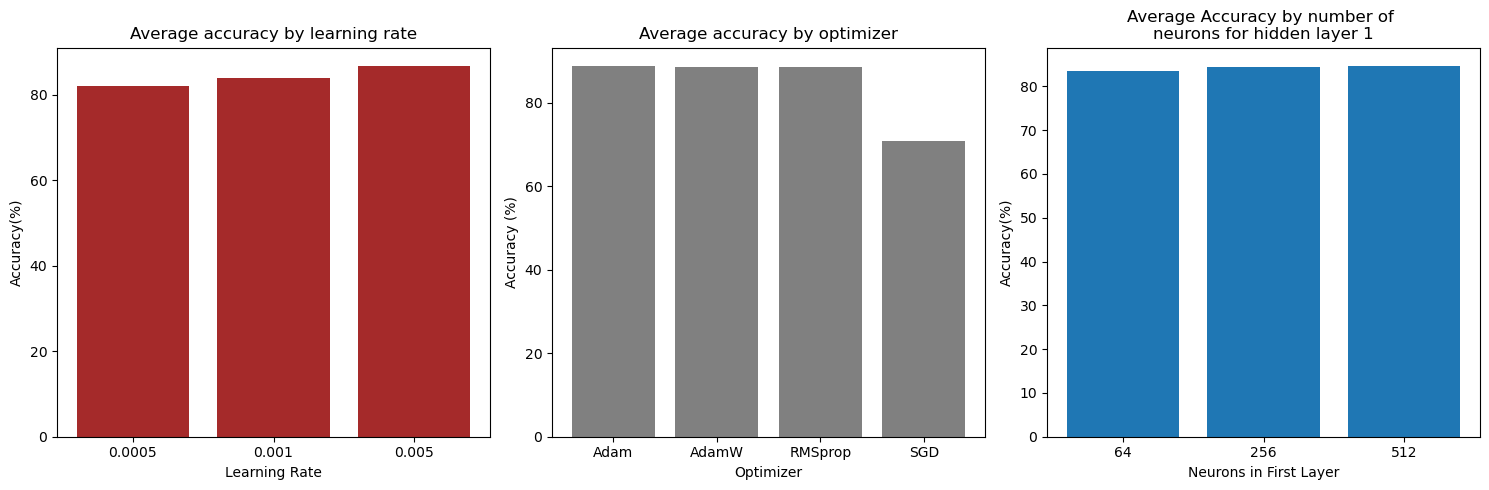

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

lr_means = results_df.groupby('learning_rate')['accuracy'].mean()#learning rate impact 
axes[0].bar(lr_means.index.astype(str), lr_means.values,color='brown')
axes[0].set_title('Average accuracy by learning rate')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Accuracy(%)')

opt_means = results_df.groupby('optimizer')['accuracy'].mean()#optimizer impact
axes[1].bar(opt_means.index, opt_means.values,color='gray')
axes[1].set_title('Average accuracy by optimizer')
axes[1].set_xlabel('Optimizer')
axes[1].set_ylabel('Accuracy (%)')

neuron_means = results_df.groupby('neurons')['accuracy'].mean()# number of neurons for hidden layer 1 impact
axes[2].bar(neuron_means.index.astype(str), neuron_means.values)
axes[2].set_title('Average Accuracy by number of \nneurons for hidden layer 1')
axes[2].set_xlabel('Neurons in First Layer')
axes[2].set_ylabel('Accuracy(%)')
plt.tight_layout()
plt.show()

# Best Model vs Baseline model :loss curves

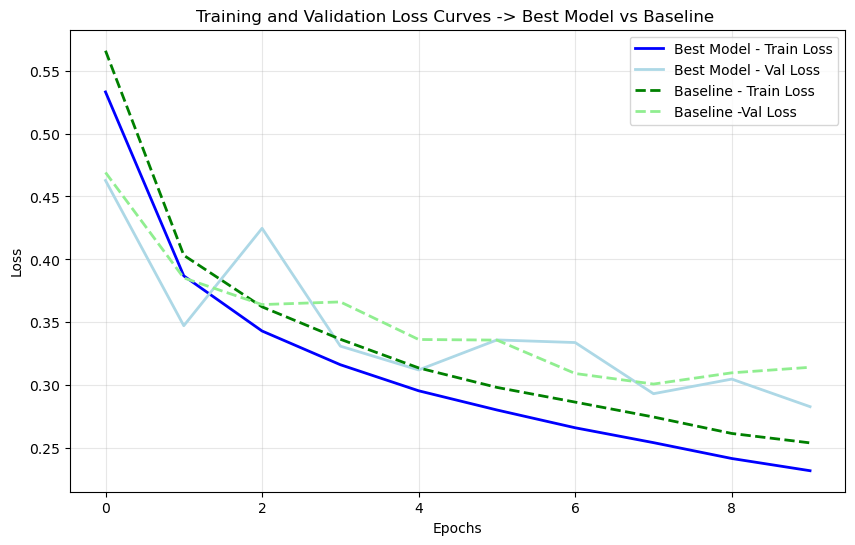

In [26]:
set_seed(56)  #best model
best_model = NeuralNet(hidden1_neurons=512)
best_optimizer = optim.RMSprop(best_model.parameters(), lr=0.0005)
best_train_loss, best_val_loss, _ = train_model(best_model, train_loader, test_loader, criterion, best_optimizer,epochs=10, verbose=False, return_history=True)

set_seed(56)  #baseline model
baseline_model = NeuralNet(hidden1_neurons=128)
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
base_train_loss, base_val_loss, _ = train_model(baseline_model, train_loader, test_loader, criterion, baseline_optimizer,epochs=10, verbose=False, return_history=True)

plt.figure(figsize=(10, 6))#loss curves
#Best model lines
plt.plot(best_train_loss, label='Best Model - Train Loss', linestyle='-',color='blue', linewidth=2)
plt.plot(best_val_loss, label='Best Model - Val Loss', linestyle='-',color='lightblue', linewidth=2)
#baselines
plt.plot(base_train_loss, label='Baseline - Train Loss', linestyle='--',color='green', linewidth=2)
plt.plot(base_val_loss, label='Baseline -Val Loss', linestyle='--',color='lightgreen', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves -> Best Model vs Baseline ')
plt.legend()
plt.grid(True, alpha=0.3)

# Best Model performance and predictions-confusion matrix

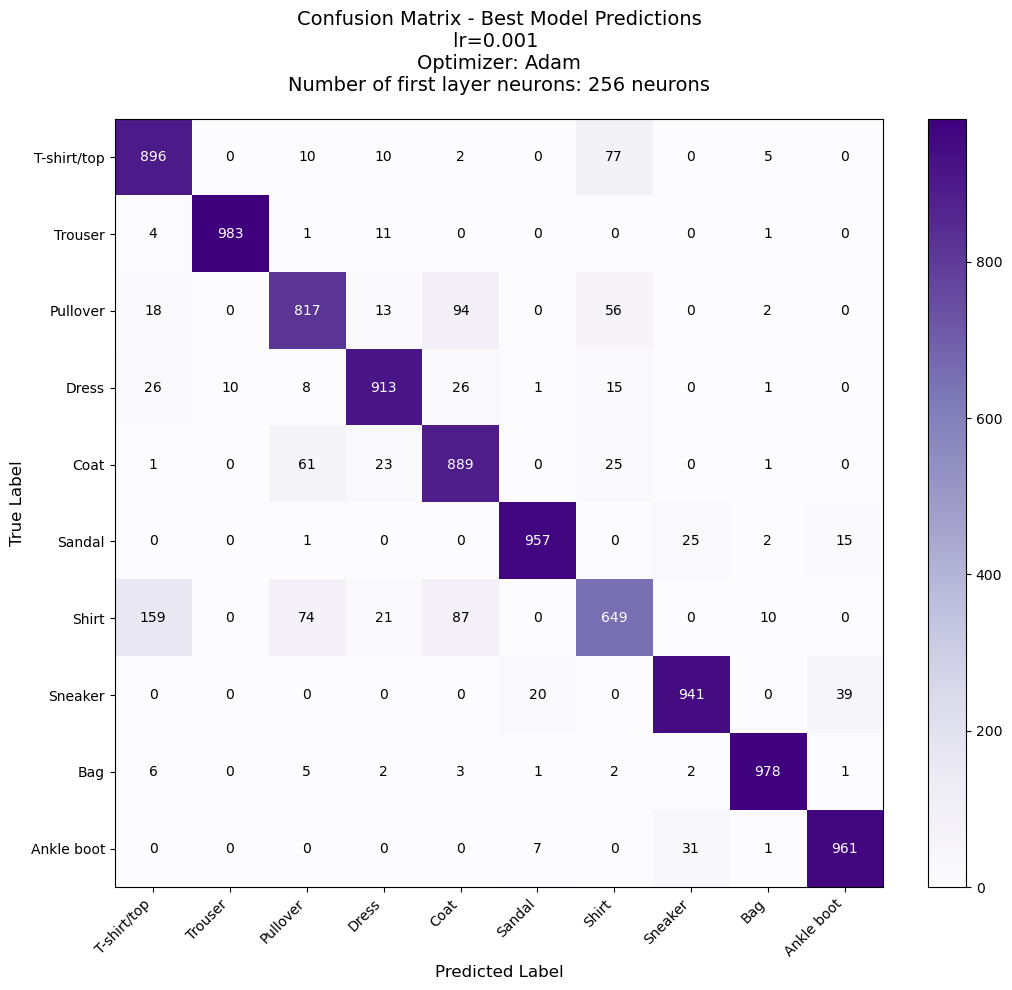

In [25]:
#predictions from best model
best_model.eval()
all_preds=[]
all_labels =[]

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())


class_names =['T-shirt/top','Trouser', 'Pullover','Dress', 'Coat','Sandal', 'Shirt','Sneaker','Bag', 'Ankle boot']
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))

im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)#plot
plt.colorbar(im, fraction=0.046,pad=0.04)

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names, rotation=45, ha='right')
plt.yticks(tick_marks,class_names)


thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),ha="center", va="center",color="white" if cm[i, j] > thresh else "black",fontsize=10)

plt.xlabel('Predicted Label',fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Best Model Predictions\nlr=0.001 \nOptimizer: Adam\nNumber of first layer neurons: 256 neurons', fontsize=14, pad=20)
plt.tight_layout()
plt.show()